<a href="https://colab.research.google.com/github/jkirky95/Horse-Race-Exercise/blob/master/horse_race_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Load the raw data


In [1]:
import json
import pandas as pd
from datetime import datetime
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
raw_data = []
for line in open('/content/drive/My Drive/assessment_log.json'):
  raw_data.append(json.loads(line))

# Assumptions


1.   All prices are in GBP (£).
2.   All trading logs are on the same horse race.

# Part 1: Sumarise and describe the trading

## Horses in the race


In [82]:
horse_data_list = []
for horse in raw_data[0]['app_data']['runners']:
  horse_dict = {key: horse[key] for key in ['handicap', 'runnerName', 'sortPriority']}
  horse_dict['selectionId'] = str(horse['selectionId']) # Force the selectionId column to be a string
  meta_dict = horse['metadata']
  horse_dict.update(meta_dict)
  horse_data_list.append(horse_dict)

horse_data = pd.DataFrame(horse_data_list)
horse_data.head()

,handicap,runnerName,sortPriority,selectionId,WEIGHT_UNITS,COLOURS_DESCRIPTION,runnerId,FORECASTPRICE_DENOMINATOR,AGE,DAM_BRED,DAMSIRE_NAME,JOCKEY_NAME,STALL_DRAW,WEARING,OFFICIAL_RATING,SIRE_YEAR_BORN,TRAINER_NAME,DAM_YEAR_BORN,WEIGHT_VALUE,CLOTH_NUMBER_ALPHA,CLOTH_NUMBER,FORM,BRED,DAM_NAME,JOCKEY_CLAIM,SIRE_BRED,ADJUSTED_RATING,OWNER_NAME,DAYS_SINCE_LAST_RUN,COLOURS_FILENAME,DAMSIRE_YEAR_BORN,DAMSIRE_BRED,FORECASTPRICE_NUMERATOR,COLOUR_TYPE,SEX_TYPE,SIRE_NAME
0,0.0,Farmix,1,27157433,pounds,"Orange, beige chevrons on sleeves, beige cap",27157433,1,5,FR,Agent Bleu,Donagh Meyler,None,None,None,1997,Miss Elizabeth Doyle,2004,160,3,3,422,FR,Quamilla,None,FR,None,M. L. Bloodstock Limited,20,c20200324clo/00074357.jpg,1987,FR,2,b,g,Al Namix
1,0.0,Florrie Webb,2,25013915,pounds,"Dark blue and red spots, check cap",25013915,1,6,IRE,Shantou,Rachael Blackmore,None,None,None,2003,Henry de Bromhead,2006,160,4,4,3,IRE,Some Catch,None,GER,None,Mrs L Halley & Mrs G Kinsella,256,c20200324clo/00859461.jpg,1993,USA,4,b,g,Prince Flori
2,0.0,Coolagh Park,3,24044533,pounds,"Dark blue, white star, white stars on sleeves,...",24044533,1,6,FR,Cyborg,Keith Donoghue,None,tongue strap,None,1999,Gordon Elliott,2001,160,2,2,2862,GB,Gaspaie,None,FR,None,Mr Alan Harte,17,c20200324clo/00080662A.jpg,1982,FR,4,b,g,Kapgarde
3,0.0,Jack Hackett,4,23225592,pounds,"Light green, black cross sashes, black sleeves...",23225592,1,6,IRE,Beneficial,P. E. Corbett,None,None,None,1997,Mrs D. A. Love,2004,168,1,1,1-44446,IRE,Corskeagh Shadow,None,UK,None,Mr Sean Reilly,23,c20200324clo/00038343.jpg,1990,UK,22,b,g,Beat Hollow
4,0.0,Rebel Gold,5,26986439,pounds,"Orange, black epaulettes, halved sleeves, oran...",26986439,1,7,IRE,Definite Article,P. D. Kennedy,None,hood and tongue strap,None,2001,Thomas Foley,2003,160,9,9,890053,IRE,Julia's Girl,None,UK,None,Miss S. Foley,7,c20200324clo/00036612.jpg,1992,UK,12,b,g,Gold Well


There are 19 different horses in this race.

## What are the markets?

In [5]:
market_dict = {
    'marketIds': [],
    'marketNames': []
}
for log in raw_data:
  app_data = log['app_data']
  if ('marketId' in app_data.keys()) & ('marketName' in app_data.keys()):
    market_dict['marketIds'].append(app_data['marketId'])
    market_dict['marketNames'].append(app_data['marketName'])

market_dict

{'marketIds': ['1.170226123', '1.170226122'],
 'marketNames': ['To Be Placed', '2m Mdn Hrd']}

Are there two markets? 
1.   **"To Be Placed"**: bet that a horse will finish in the top three.
2.   **"2m Mdn Hrd"**: this is actually the *race description* (I'm not sure why it was down as a market name). It means that it is a race of 2 miles over hurdles for horses that are maidens. A maiden is a horse that has not won a race over small jumps (it can have won a flat race).

Since "2 Mdn Hrd" is a race description and not a market type, I will assume that all orders are in the "To be placed" market of a race that is of 2 miles over hurdles for horses that are maidens.

## The orders

### Collecting orders into a dataframe

First, we convert the order data into a pandas dataframe.


In [6]:
order_list = []
for log in raw_data:
  app_data = log.get('app_data', {})
  market_id = app_data.get('marketId', None)
  last_match_time = app_data.get('lastMatchTime', None)
  for horse in app_data.get('runners', []):
    orders = horse.get('orders', [])
    # Sometimes the orders are None, so we avoid this case
    if orders != None:
      for order in orders:
        order['lastPriceTraded'] = horse.get('lastPriceTraded', None)
        order['selectionId'] = str(horse.get('selectionId', '')) # Force the selectionId column to be a string
        order['marketId'] = market_id
        order['lastMatchTime'] = last_match_time
        order_list.append(order)

In [7]:
order_df = pd.DataFrame(order_list)
# Sort the data by lastMatchTime
order_df.sort_values(by = 'lastMatchTime', inplace = True)
# Convert the lastMatchTime column to datetime
order_df['lastMatchTime']= pd.to_datetime(order_df['lastMatchTime'], format="%Y-%m-%dT%H:%M:%S.%f")
# Add the horse names to the df
horse_cols = ['selectionId', 'runnerName']
order_df = order_df.merge(horse_data[horse_cols], how = 'left', on = 'selectionId')

There are duplicates in the order dataframe with the KEY = [betId, selectionId, status, orderType, sizeRemaining]. The following code block removes these (taking the first row).

In [8]:
ORDER_KEY = ['betId', 'selectionId', 'status', 'side', 'orderType', 'sizeRemaining']
order_df.drop_duplicates(
    subset = ORDER_KEY,
    keep = 'first',
    inplace = True
)

### What kind of orders are being sent?

In [9]:
order_df['orderType'].unique()

array(['LIMIT'], dtype=object)

**Only Limit orders** are being sent: 

*   Limit orders are instructions that give a size and a price.
*   Limit orders go to the limit order book and are only excecuted if another party "walks the book" by sending a market order. This can be seen in the code block below.
*   Only a fraction of the limit order volume may be met.
*   Limit orders are usually queued so that older orders for the same price are the first to get hit.

In [10]:
order_df['status'].unique()

array(['EXECUTABLE', 'EXECUTION_COMPLETE'], dtype=object)

### How many limit orders are we sending?
Here we only consider the limit orders sent, these are the rows with 'orderType' = 'EXECUTABLE'.

Text(0, 0.5, 'Frequency')

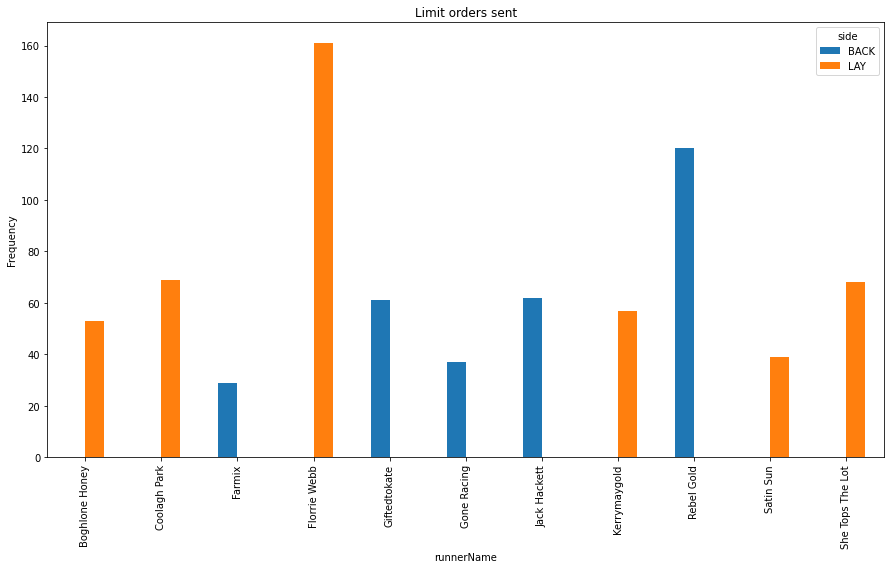

In [11]:
orders_sent = order_df[order_df['status'] == 'EXECUTABLE']
orders_sent_frequencies = orders_sent.groupby(by = ['runnerName', 'side']).size()
ax = orders_sent_frequencies.unstack('side').plot.bar(title = 'Limit orders sent', figsize=(15,8))
ax.set_ylabel('Frequency')

The graph above shows that we **only send limit orders of a particular side** (either back or lay) on each horse. 

### How many orders are executed?
Orders executed are the rows with 'orderType' = 'EXECUTION_COMPLETE'.

Text(0, 0.5, 'Frequency')

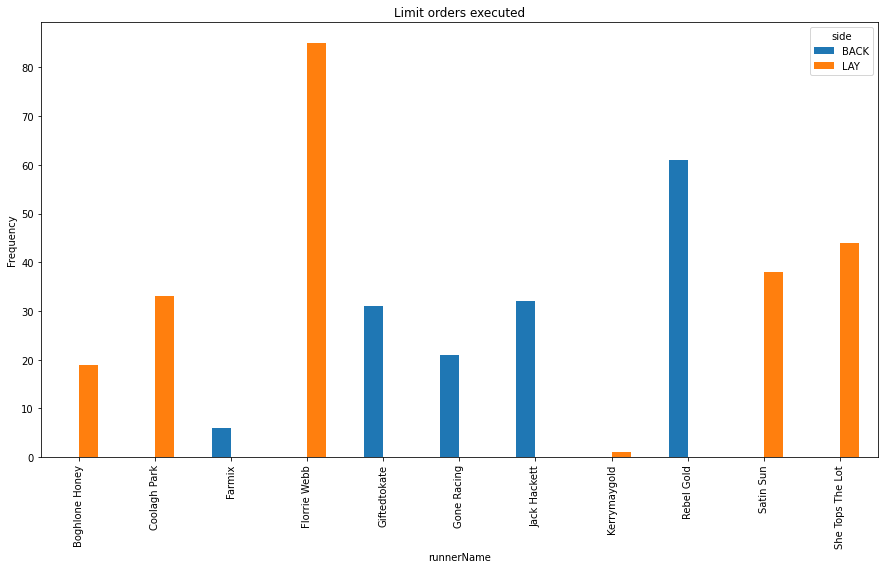

In [12]:
orders_executed = order_df[order_df['status'] == 'EXECUTION_COMPLETE']
orders_executed_frequencies = orders_executed.groupby(by = ['runnerName', 'side']).size()
ax = orders_executed_frequencies.unstack('side').plot.bar(title = 'Limit orders executed', figsize=(15,8))
ax.set_ylabel('Frequency')

Here we see that not all orders sent end up being executed. For example, of the 120 BACK side limit orders for Rebel Gold sent, 61 were fully executed.

### What is the total size (in GBP) of orders sent for each horse?

Text(0, 0.5, 'Amount GBP £')

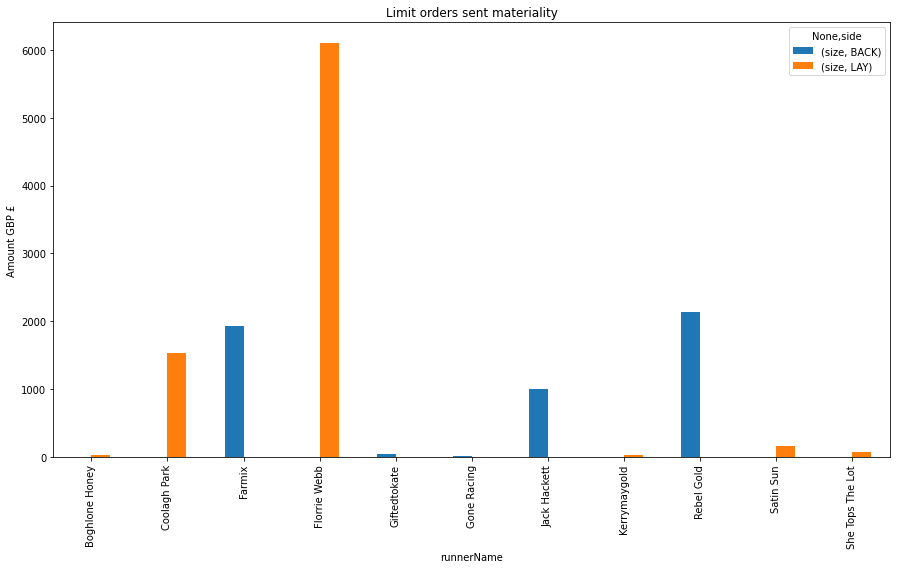

In [13]:
orders_sent_amount = orders_sent.groupby(by = ['runnerName', 'side']).agg({'size': 'sum'})
ax = orders_sent_amount.unstack('side').plot.bar(title = 'Limit orders sent materiality', figsize=(15,8))
ax.set_ylabel('Amount GBP £')

The most we try to bet on a horse is just over £6,000 on Florrie Webb.

### How much of this is executed?


Text(0, 0.5, 'Amount GBP £')

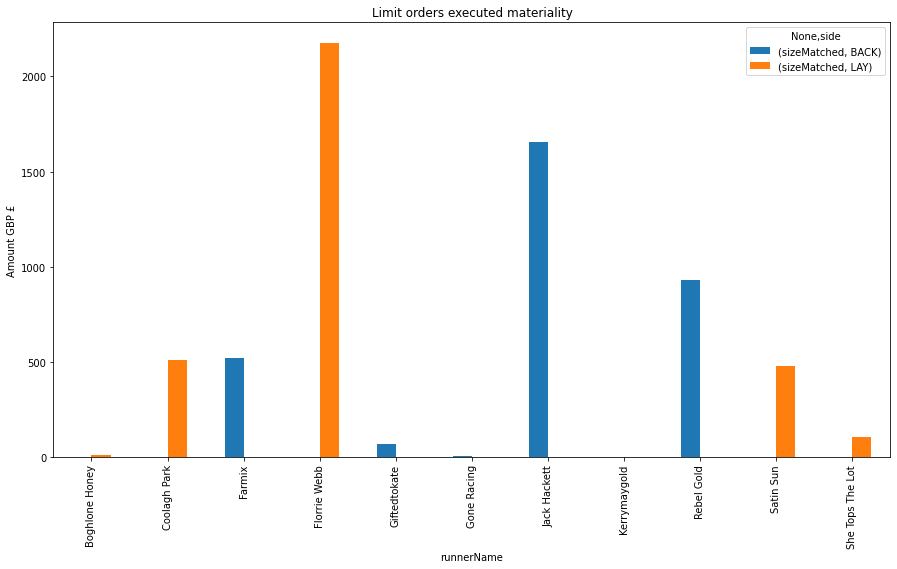

In [37]:
orders_executed_amount = orders_executed.groupby(by = ['runnerName', 'side']).agg({'sizeMatched': 'sum'})
ax = orders_executed_amount.unstack('side').plot.bar(title = 'Limit orders executed materiality', figsize=(15,8))
ax.set_ylabel('Amount GBP £')

Almost two thirds of the GBP value of orders sent laying Florrie Web are not executed.

Note that, the horse Jack Hackett has a **larger amount executed** than it does for orders sent. Therefore, rows are appearing with EXECUTION_COMPLETE status without having a previous order with EXECUTABLE status for a given betId. This is due to these limit orders being matched as soon as they are sent. See the code block below for an example, the 'placedDate' and 'lastMatchTime' are the same.

In [64]:
order_df.loc[order_df['betId'] == '198774867194', ['status', 'orderType', 'placedDate', 'lastMatchTime', 'sizeMatched', 'runnerName']]

,status,orderType,placedDate,lastMatchTime,sizeMatched,runnerName
111222,EXECUTION_COMPLETE,LIMIT,2020-03-24 13:59:47,2020-03-24 13:59:47.456,598.47,Jack Hackett


# Part 2: Evaluate the trading

## Choice of success metric

Before I analyse the quality of the trading, let's investigate effect of placing a number of equal-sized back bets at different prices.

Suppose that we make $N$ backing bets of unit size at prices $P_1, P_2, ..., P_N$. Our PnL after the race is

---

$$\text{PnL} = \begin{cases}
P_1 + P_2 + ... + P_N = N\bar{P} &\text{If the horse places,}\\
-N &\text{Otherwise,}
\end{cases}$$

---

where $\bar{P}$ is the average price. Therefore, these back bets are equivalent to one single back bet of size $N$ at the price $\bar{P}$.

What about the more general case when the orders are of sizes $S_1, S_2, ..., S_N$? The PnL is

---

$$\text{PnL} = \begin{cases}
S_1 P_1 + S_2 P_2 + ... + S_N P_N = \left(\sum_{i=1}^N S_i\right)\bar{P}_W &\text{If the horse places,}\\
\sum_{i=1}^N S_i &\text{Otherwise,}
\end{cases}$$

---

where $\bar{P}_W$ is the volume-weighted average price (VWAP). Therefore, these back bets are equivalent to one single back bet of size $\sum_{i=1}^N S_i $ at the VWAP $\bar{P}_W$.

Note that the above logic is valid for both backing and laying, since their PnL's are exactly opposite. 

When backing (resp. laying) a single bet, we want the price to be high (low), therefore **a good trading algorithm will have a high backing VWAP and a low laying VWAP**. 

## Evaluating the trading

Since the majority of the traded volume (~61%) was on either Florrie Webb or Jack Hackett, we will only evaluate the trading on these horses.

Note that, in the trading, Jack Hackett is being backed, and Florrie Webb is being layed.

### Florrie Webb

In [16]:
pd.options.mode.chained_assignment = None  # To disable settingWithCopyWarnings
florrie_webb = orders_executed[(orders_executed['runnerName'] == 'Florrie Webb') ]
florrie_webb['volPrice'] = florrie_webb['sizeMatched']* florrie_webb['lastPriceTraded']
florrie_webb['cumVol'] = florrie_webb['sizeMatched'].cumsum()
florrie_webb['cumVolPrice'] = florrie_webb['volPrice'].cumsum()
florrie_webb['vwap'] = florrie_webb['cumVolPrice']/ florrie_webb['cumVol']

Text(0, 0.5, 'Price')

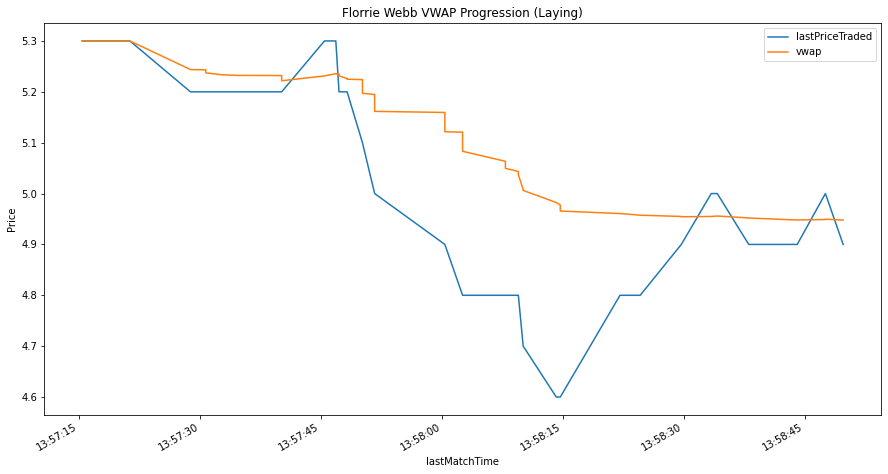

In [17]:
ax = florrie_webb.plot.line(title = 'Florrie Webb VWAP Progression (Laying)', x = 'lastMatchTime', y = ['lastPriceTraded', 'vwap'], figsize = (15,8))
ax.set_ylabel('Price')

The plot above compares the last price traded to the obtained VWAP during the trading session. Recall that we are laying Florrie Webb, so the ojective is for the VWAP to be as small as possible.

Looking at the evolution of the last price traded, a good retrospective trading strategy would have been:

1.   Not lay much until about 13:57:50.
2.   Lay more frequently between 13:57:50 and 13:58:30 (being careful not to have much maret impact).
3.   Lay less frequently after 13:58:30.





Text(0, 0.5, 'Cumulative Lay Bet Size (£ GBP)')

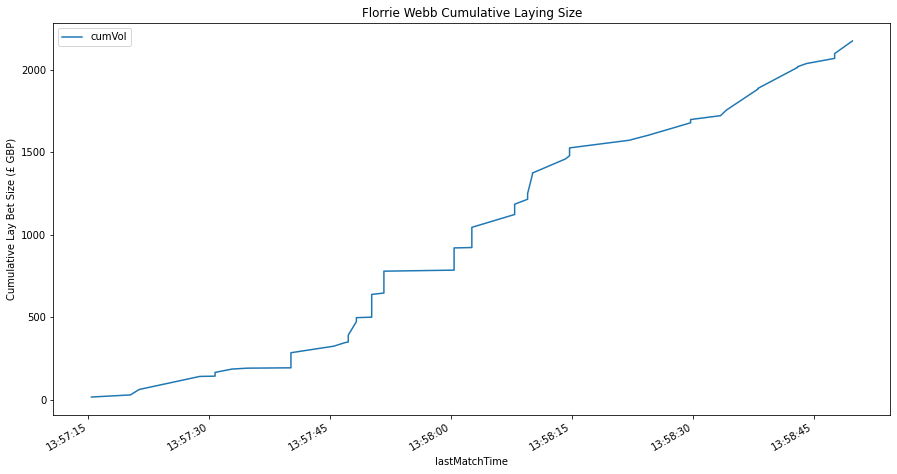

In [18]:
ax = florrie_webb.plot.line( title = 'Florrie Webb Cumulative Laying Size', x = 'lastMatchTime', y = ['cumVol'], figsize = (15,8))
ax.set_ylabel('Cumulative Lay Bet Size (£ GBP)')

The above plot shows the evolutiion of the cumulative lay bet size during the trading session. How well does this volume profile follow the good trading strategy outlined above?
1.   Yes, the increase in laying amount is minimal up to 13:57:50
2.   Yes, we do see a large increase in cumulative lay size between 13:57:50 and 13:58:15, however trading seems to stall between 13:58:15 and 13:58:30.
3.   Yes, Lay trading is less frequently after 13:58:30, however the rate of trading in this period may have been too high.

Overall, I think the trading on Florrie Webb was successful.

### Jack Hackett

In [19]:
pd.options.mode.chained_assignment = None  # To disable settingWithCopyWarnings
jack_hackett = orders_executed[(orders_executed['runnerName'] == 'Jack Hackett') ]
jack_hackett['volPrice'] = jack_hackett['sizeMatched']* jack_hackett['lastPriceTraded']
jack_hackett['cumVol'] = jack_hackett['sizeMatched'].cumsum()
jack_hackett['cumVolPrice'] = jack_hackett['volPrice'].cumsum()
jack_hackett['vwap'] = jack_hackett['cumVolPrice']/ jack_hackett['cumVol']

Text(0, 0.5, 'Price')

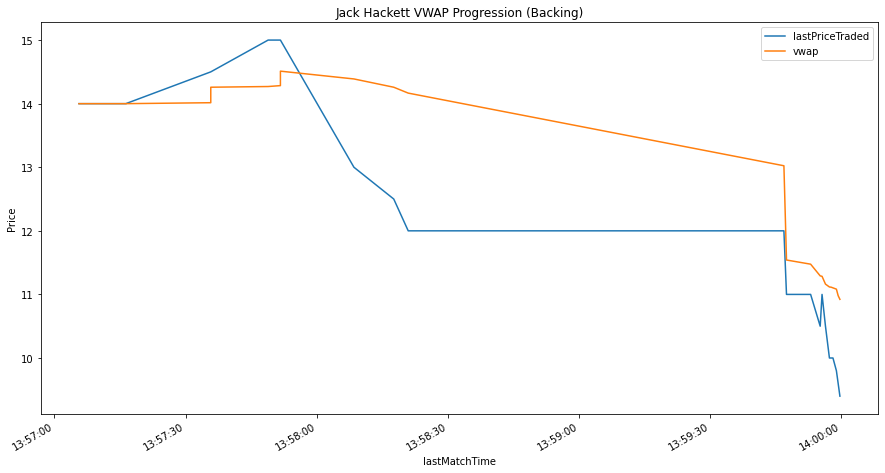

In [20]:
ax = jack_hackett.plot.line(title = 'Jack Hackett VWAP Progression (Backing)', x = 'lastMatchTime', y = ['lastPriceTraded', 'vwap'], figsize = (15,8))
ax.set_ylabel('Price')

The plot above compares the last price traded to the obtained VWAP during the trading session. Recall that we are backing Jack Hackett, so the ojective is for the VWAP to be as large as possible.

Looking at the evolution of the last price traded, a good retrospective trading strategy would have been:

1.   Back frequently until 13:58:20.
2.   Back less frequently between 13:58:20 and 13:59:45.
3.   Hardly back after 13:59:45.

Text(0, 0.5, 'Cumulative Back Bet Size (£ GBP)')

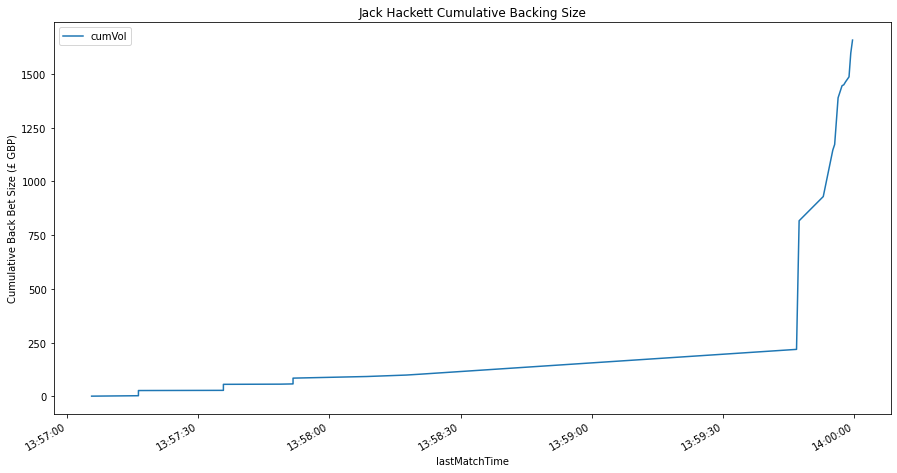

In [21]:
ax = jack_hackett.plot.line( title = 'Jack Hackett Cumulative Backing Size', x = 'lastMatchTime', y = ['cumVol'], figsize = (15,8))
ax.set_ylabel('Cumulative Back Bet Size (£ GBP)')

The above plot shows the evolution of the cumulative back bet size during the trading session. How well does this volume profile follow the good trading strategy outlined above? Not well, the majority of the trading took place after 13:59:45, when the price was especially low. The overall VWAP would have been vastly better if the backing was spread out over the session.

# Part 3: Plan for improvements

## Adding limit order book snapshot information

To sugguest improvements, lets first create the order dataframe once more, but this time we include limit order book snapshot information.

I will add the leading (closest to mid-price) back and lay price, as well as their associated volumes in the LOB.

In [65]:
order_list = []
for log in raw_data:
  app_data = log.get('app_data', {})
  last_match_time = app_data.get('lastMatchTime', None)
  for horse in app_data.get('runners', []):
    orders = horse.get('orders', [])
    # Sometimes the orders are None, so we avoid this case
    if orders != None:
      for order in orders:
        order['lastPriceTraded'] = horse.get('lastPriceTraded', None)
        order['selectionId'] = str(horse.get('selectionId', '')) # Force the selectionId column to be a string
        order['lastMatchTime'] = last_match_time

        book_snapshot = horse.get('ex', {})

        back_lob_side = book_snapshot.get('availableToBack', [{}])
        if back_lob_side == []:
          back_lob_side = [{}]
        leading_back_dict = back_lob_side[0]
        order['leadingBackSize'] = leading_back_dict.get('size', None) 
        order['leadingBackPrice'] = leading_back_dict.get('price', None)
        
        lay_lob_side = book_snapshot.get('availableToLay', [{}])
        if lay_lob_side == []:
          lay_lob_side = [{}]
        leading_lay_dict = lay_lob_side[0]
        order['leadingLaySize'] = leading_lay_dict.get('size', None)
        order['leadingLayPrice'] = leading_lay_dict.get('price', None)

        order_list.append(order)

In [67]:
order_df = pd.DataFrame(order_list)
# Sort the data by placedDate
order_df.sort_values(by = 'placedDate', inplace = True)
# Convert the date columns to datetime
order_df['placedDate']= pd.to_datetime(order_df['placedDate'], format="%Y-%m-%dT%H:%M:%S.%f")
order_df['lastMatchTime']= pd.to_datetime(order_df['lastMatchTime'], format="%Y-%m-%dT%H:%M:%S.%f")
# Add the horse names to the df
horse_cols = ['selectionId', 'runnerName']
order_df = order_df.merge(horse_data[horse_cols], how = 'left', on = 'selectionId')

In [68]:
ORDER_KEY = ['betId', 'selectionId', 'side', 'orderType', 'sizeRemaining']
order_df.drop_duplicates(
    subset = ORDER_KEY,
    keep = 'first',
    inplace = True
)

Note that we don't include 'status' in the ORDER_KEY definition above. This is because some orders can appear as 'EXECUTION_COMPLETE' without having appeared previously.

## Improvement plan for Jack Hackett

### Spread out the volume
My recomendation comes from looking at the last graph in the 'Part 2' section above. Most of the backing occurs near the end where the price is at its lowest. To reduce the risk of this occuring, the backing should be spread out over the entire trading session.

Suppose that the total we want to send out as orders during the trading session is $£T$. A sensible sugguestion would be:

*   Divide the total into $N$ parts of size $T/N$
*   Send one order of size $T/N$ at the leading price at $N$ equidistant times during the trading session.


However, we have to keep our market impact in mind.

The graph below shows the order size of back limit orders at the leading price as a percentage of the total order size at that price. We see a huge spike at the end, which is most probably the cause of the drop in the price after 13:59:45.



Text(0, 0.5, 'Order Size %')

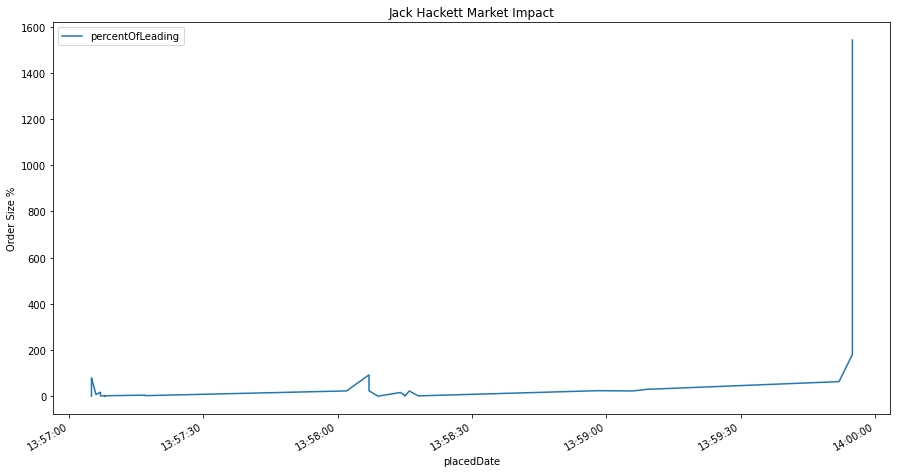

In [84]:
jack_hackett = order_df[(order_df['runnerName'] == 'Jack Hackett') & (order_df['price'] == order_df['leadingLayPrice'])]
jack_hackett['percentOfLeading'] = 100 * jack_hackett['size'] / jack_hackett['leadingLaySize']
ax = jack_hackett.plot.line(title = 'Jack Hackett Market Impact', x = 'placedDate', y = ['percentOfLeading'], figsize = (15,8))
ax.set_ylabel('Order Size %')

Therefore, I sugguest that we add the restriction on the size of the order that we send at a given price:  

*   The order size at a given price should not be greater than a certain percentage $p\%$ (say 50%) of the existing size at that price.
*   If the order (of size $T/N$) is greater than $p\%$ of the existing size, then we send $p\%$ of the existing size at this price and move onto the next best price to try and post the rest of our order, and so on.



The above trading plan should be tested against the existing algorithm on multiple different trading sessions. If the algorithm has a better VWAP, then it would be considered as an improvement on the existing algorithm.